# Salt stress downregulates AhrC

In [2]:
from __future__ import print_function, division, absolute_import

import sys

import qminospy
from qminospy.me2 import ME_NLP

# python imports
from copy import copy
import re
from os.path import join
from collections import defaultdict
import pickle

# third party imports
import pandas
import cobra
from tqdm import tqdm
import numpy as np
import scipy
import matplotlib.pyplot as plt

# COBRAme
import cobrame
from cobrame.util import building, mu, me_model_interface
from cobrame.io.json import save_json_me_model, save_reduced_json_me_model

# ECOLIme
import bacillusme
from bacillusme import (transcription, translation, flat_files, generics, formulas, compartments)
from bacillusme.util.helper_functions import *
%load_ext autoreload
%autoreload 2
print(cobra.__file__)
print(cobrame.__file__)
print(bacillusme.__file__)

/home/jt/Downloads/cobrapy-0.5.11/cobra/__init__.py
/home/jt/UCSD/cobrame-master/cobrame/__init__.py
/home/jt/UCSD/bacillusme-master/bacillusme/__init__.py


Load

In [3]:
eco_directory = join(flat_files.ecoli_files_dir, 'iJO1366.json')
ijo_directory = join(flat_files.ecoli_files_dir, 'iYO844.json')
uni_directory = join(flat_files.ecoli_files_dir, 'universal_model.json')

eco = cobra.io.load_json_model(eco_directory)
bsub = cobra.io.load_json_model(ijo_directory)
uni = cobra.io.load_json_model(uni_directory)

bsub.optimize()
base_mu = bsub.solution.f

In [174]:
gene_dictionary = pd.read_csv('gene_name_dictionary.csv',index_col=1)
ions = ['na1_e','ca2_e','zn2_e','k_e']

## RNASeq data

In [175]:
data = pd.read_csv('rna_seq/RNAseq_raw.csv',index_col=1)

RNAseq data appears to be normalized. That means that roughly they have the same numbre of cells.

In [176]:
samples = data.columns
control_data = data[samples[samples.str.contains('SMM_')]]
stress_data = data[samples[samples.str.contains('Salt')]]
fold_change = np.divide(stress_data,control_data)

### Arginine biosynthesis

Text(0.5, 1.0, 'Arginine biosynthetic gene expression ')

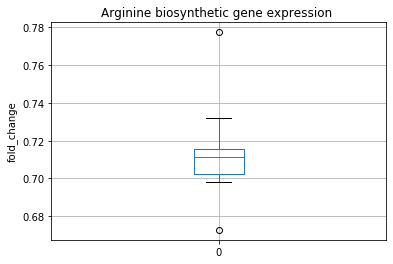

In [6]:
genes = ['argG', 'argH', 'argC', 'argJ', 'argB', 'argD', 'argF', 'carA', 'carB']
fold_change.loc[gene_dictionary.loc[genes]['locus_id']].mean(axis=1).to_frame().boxplot()
plt.ylabel('fold_change')
plt.title('Arginine biosynthetic gene expression ')

Arginine biosynthesis is downregulated in salt stress.

### Transporter expression

In [7]:
# Identify uptake and secretion transporters
uptake_rxns = get_transport_reactions(bsub,'na1_e',verbose=0)
transporter_ids=[]
for rxn in uptake_rxns:
    genes_uptake = rxn.genes
    transporters = [gene.id for gene in genes_uptake]
    for t in transporters:
        transporter_ids.append(t)
        
secretion_rxns = get_transport_reactions(bsub,'na1_e',verbose=0,comps=['c','e'])
secretor_ids=[]
for rxn in secretion_rxns:
    genes_secretion = rxn.genes
    transporters = [gene.id for gene in genes_secretion]
    for t in transporters:
        secretor_ids.append(t)

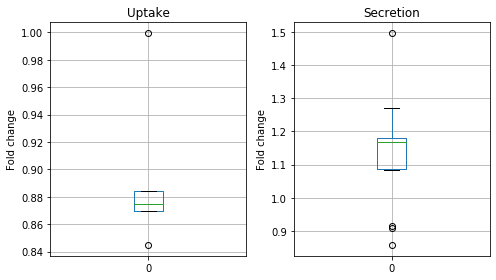

In [8]:

plt.figure(figsize=(7,4))
plt.subplot(1,2,1)
fold_change.loc[transporter_ids].mean(axis=1).to_frame().boxplot()
plt.title('Uptake')
plt.ylabel('Fold change')

plt.subplot(1,2,2)
fold_change.loc[secretor_ids].mean(axis=1).to_frame().boxplot()
plt.title('Secretion')
plt.ylabel('Fold change')

plt.tight_layout()

Downregulation of uptake transporters means that either the same or a reduced amount of uptake transporters should be expressed in salt stress. That means that to properly model this in the ME-model it is necessary to add transport reactions that do not induce expression of transporters.

### Up and downregulation

In [209]:
from scipy.stats import ttest_ind,t
alpha = 0.05
decision_df = pd.DataFrame(index=control_data.index,columns=['reg'])
for gene in tqdm(decision_df.index):
    
    a = control_data.loc[gene]
    b = stress_data.loc[gene]
    tval = ttest_ind(b,a).statistic

    pval = t.cdf(tval,df=(len(a)-1)+(len(b)-1))
    if pval > 0.95: # b>a?  
        decision_df.loc[gene]['reg'] = 1
    elif pval < 0.05: # b<a?
        decision_df.loc[gene]['reg'] = -1
    else:
        decision_df.loc[gene]['reg'] = 0



  0%|          | 0/5875 [00:00<?, ?it/s]

  0%|          | 24/5875 [00:00<00:24, 239.29it/s]

  1%|          | 44/5875 [00:00<00:26, 222.43it/s]

  1%|          | 65/5875 [00:00<00:27, 211.90it/s]

  2%|▏         | 93/5875 [00:00<00:25, 227.94it/s]

  2%|▏         | 122/5875 [00:00<00:23, 240.57it/s]

  2%|▏         | 145/5875 [00:00<00:24, 235.68it/s]

  3%|▎         | 172/5875 [00:00<00:23, 242.21it/s]

  3%|▎         | 196/5875 [00:00<00:23, 239.21it/s]

  4%|▎         | 220/5875 [00:00<00:23, 237.89it/s]

  4%|▍         | 243/5875 [00:01<00:24, 230.33it/s]

  5%|▍         | 266/5875 [00:01<00:24, 226.28it/s]

  5%|▍         | 289/5875 [00:01<00:25, 217.51it/s]

  5%|▌         | 313/5875 [00:01<00:25, 221.92it/s]

  6%|▌         | 336/5875 [00:01<00:26, 207.51it/s]

  6%|▌         | 358/5875 [00:01<00:26, 210.26it/s]

  7%|▋         | 386/5875 [00:01<00:24, 226.40it/s]

  7%|▋         | 411/5875 [00:01<00:23, 230.19it/s]

  7%|▋         | 436/5875 [00:01<00:23, 234.85it/s]

  8%|▊

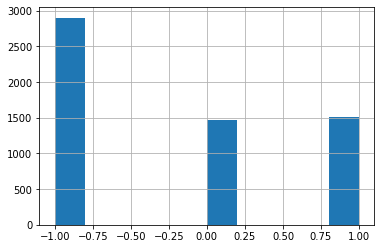

In [278]:
decision_df['reg'].hist()

## M-model simulations

In [8]:
bsub = cobra.io.load_json_model(ijo_directory)
na1_e = bsub.metabolites.na1_e
## Separate sodium entrance and exit
bsub.reactions.EX_na1_e.lower_bound = 0
bsub.reactions.EX_na1_e.upper_bound = 0

# Create sodium metabolites
na1_in = cobra.Metabolite(id='na1_in')
na1_out = cobra.Metabolite(id='na1_out')
bsub.add_metabolites([na1_in,na1_out])

# Sodium uptake
rxn = cobra.Reaction(id='EX_na1_in')
rxn.add_metabolites({
    na1_in:-1.0
})
rxn.lower_bound = -1000
rxn.upper_bound = 0
bsub.add_reaction(rxn)
print(rxn.reaction)
# Sodium exit
rxn = cobra.Reaction(id='DM_na1_out')
rxn.add_metabolites({
    na1_out:-1.0
})
rxn.lower_bound = 0
rxn.upper_bound = 1000
bsub.add_reaction(rxn)
print(rxn.reaction)

na1_in <=> 
na1_out <=> 


In [9]:
uptake_rxns = get_reactions_of_met(bsub,'na1_e',s = -1,verbose=0)
exit_rxns = get_reactions_of_met(bsub,'na1_e',s = 1,verbose=0)

for rxn in uptake_rxns:
    coeff = rxn.pop(na1_e)
    rxn.add_metabolites({na1_in:coeff})
    print(rxn.reaction)
for rxn in exit_rxns:
    coeff = rxn.pop(na1_e)
    rxn.add_metabolites({na1_out:coeff})
    print(rxn.reaction)

mal__L_e + na1_in --> mal__L_c + na1_c
bilea_e + na1_in --> bilea_c + na1_c
3.0 na1_in + pi_e --> 3.0 na1_c + pi_c
glu__L_e + na1_in --> glu__L_c + na1_c
atp_c + h2o_c + na1_c --> adp_c + h_c + na1_out + pi_c
2.0 h_e + lac__L_c + mal__L_e + na1_c --> 2.0 h_c + lac__L_e + mal__L_c + na1_out
h_e + na1_c --> h_c + na1_out


In [10]:
# Sodium rates and simulation
na_rates = -np.arange(0,5,0.1)*1e-3
flux_dict = dict()
for rate in na_rates:
    bsub.reactions.get_by_id('EX_na1_in').lower_bound = rate
    bsub.reactions.get_by_id('EX_na1_in').upper_bound = rate
    solution = bsub.optimize()
    flux_dict[rate] = solution.x_dict
flux_responses = pd.DataFrame.from_dict(flux_dict)

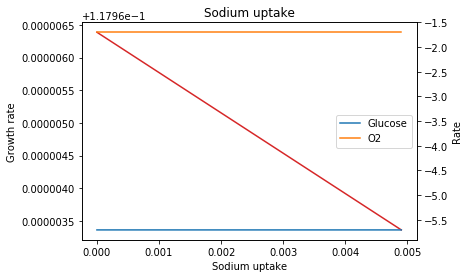

In [11]:
fig,ax1 = plt.subplots()
plt.title('Sodium uptake')

ax1.plot(-flux_responses.loc['EX_na1_in'],flux_responses.loc['BIOMASS_BS_10'],
            label = 'growth',color='tab:red')
ax1.set_xlabel('Sodium uptake')
ax1.set_ylabel('Growth rate')

ax2 = ax1.twinx()
ax2.plot(-flux_responses.loc['EX_na1_in'],flux_responses.loc['EX_o2_e'],
            label = 'Glucose')
ax2.plot(-flux_responses.loc['EX_na1_in'],flux_responses.loc['EX_glc__D_e'],
            label = 'O2')
ax2.set_ylabel('Rate')

ax2.legend()

M-model predicts an increase in growth rate at increased sodium uptake

In [12]:
gene_dictionary = pd.read_csv('gene_name_dictionary.csv',index_col=1)

In [13]:
flux_responses = pd.DataFrame.from_dict(flux_dict)

/home/jt/UCSD/ME_modelling/ME_env/lib/python3.6/site-packages/ipykernel_launcher.py:7 RuntimeWarning: invalid value encountered in true_divide


(0.9, 1.1)

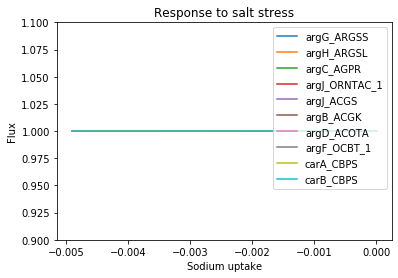

In [20]:
import pandas as pd
genes = ['argG', 'argH', 'argC', 'argJ', 'argB', 'argD', 'argF', 'carA', 'carB']
for idx,gene in enumerate(gene_dictionary.loc[genes]['locus_id'].values):
    rxns = bsub.genes.get_by_id(gene).reactions
    for rxn in rxns:
        flux_profile = abs(flux_responses.loc[rxn.id].values)
        flux_profile /= max(flux_profile)
        plt.plot(na_rates,flux_profile,label=genes[idx]+'_'+rxn.id)
plt.title('Response to salt stress')
plt.xlabel('Sodium uptake')
plt.ylabel('Flux')
plt.legend()
plt.ylim([0.9, 1.1])

Is it an artifact of growth rate increase?

In [16]:
bsub.reactions.get_by_id('EX_glc__D_e').lower_bound = -10
bsub.reactions.get_by_id('BIOMASS_BS_10').lower_bound = base_mu
bsub.reactions.get_by_id('BIOMASS_BS_10').upper_bound = base_mu

bsub.objective = 'EX_glc__D_e'
bsub.reactions.get_by_id('EX_glc__D_e').objective_coefficient = -1.

# Sodium rates and simulation
na_rates = -np.arange(0,5,0.1)*1e-3
flux_dict = dict()
for rate in na_rates:
    bsub.reactions.get_by_id('EX_na1_in').lower_bound = rate
    bsub.reactions.get_by_id('EX_na1_in').upper_bound = rate
    solution = bsub.optimize()
    flux_dict[rate] = solution.x_dict
flux_responses = pd.DataFrame.from_dict(flux_dict)

/home/jt/UCSD/ME_modelling/ME_env/lib/python3.6/site-packages/ipykernel_launcher.py:6 RuntimeWarning: invalid value encountered in true_divide


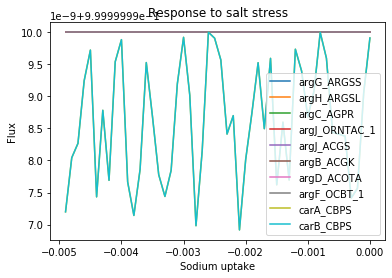

In [17]:
genes = ['argG', 'argH', 'argC', 'argJ', 'argB', 'argD', 'argF', 'carA', 'carB']
for idx,gene in enumerate(gene_dictionary.loc[genes]['locus_id'].values):
    rxns = bsub.genes.get_by_id(gene).reactions
    for rxn in rxns:
        flux_profile = abs(flux_responses.loc[rxn.id].values)
        flux_profile /= max(flux_profile)
        plt.plot(na_rates,flux_profile,label=genes[idx]+'_'+rxn.id)
plt.title('Response to salt stress')
plt.xlabel('Sodium uptake')
plt.ylabel('Flux')
plt.legend()

M-model is not able to capture the decrease in AhrC regulon

## ME-model simulations

In [5]:
with open('../me_models/solution.pickle', 'rb') as solution:
    me = pickle.load(solution)

In [7]:
get_reactions_of_met(me,'cl_c')

( CLt 0.0 1000.0 ) 	 cl_e --> cl_c


[<MEReaction CLt at 0x7f870a82e630>]

Add those reactions that account for osmosis

In [20]:
# Add a copy of transport reactions that do not need a transporter
uptake_rxns = get_transport_reactions(me,'na1_e',comps=['e','c'],verbose=0)
osm_rxns = []
for rxn in uptake_rxns:
    stoich = rxn.stoichiometric_data.stoichiometry
    osm_id = rxn.id.split('_FWD')[0]+'_osm'
    
    if not hasattr(me.reactions,osm_id):
        osm_rxn = cobrame.MEReaction(osm_id)
        me.add_reaction(osm_rxn)

        osm_rxn.add_metabolites(stoich)
        osm_rxn.lower_bound=0
        osm_rxn.upper_bound=1000
        osm_rxns.append(osm_rxn)
        print(osm_rxn.id,osm_rxn.lower_bound,osm_rxn.upper_bound,osm_rxn.reaction)   


GLUt4_osm 0 1000 glu__L_e + na1_e <=> glu__L_c + na1_c
BILEt4_osm 0 1000 bilea_e + na1_e <=> bilea_c + na1_c
PIt7_osm 0 1000 3.0 na1_e + pi_e <=> 3.0 na1_c + pi_c
MALt4_osm 0 1000 mal__L_e + na1_e <=> mal__L_c + na1_c


Add sodium uptake and exit separately

In [21]:
from cobrame import MEReaction,Metabolite

na1_e = me.metabolites.na1_e
## Separate sodium entrance and exit
me.reactions.EX_na1_e.lower_bound = 0
me.reactions.EX_na1_e.upper_bound = 0

# Create sodium metabolites
na1_in = Metabolite(id='na1_in')
na1_out = Metabolite(id='na1_out')
me.add_metabolites([na1_in,na1_out])

# Sodium uptake
rxn = MEReaction(id='EX_na1_in')
rxn.add_metabolites({
    na1_in:-1.0
})
rxn.lower_bound = -1000
rxn.upper_bound = 0
me.add_reaction(rxn)
print(rxn.id,rxn.reaction)
# Sodium exit
rxn = MEReaction(id='DM_na1_out')
rxn.add_metabolites({
    na1_out:-1.0
})
rxn.lower_bound = 0
rxn.upper_bound = 1000
me.add_reaction(rxn)
print(rxn.id,rxn.reaction)

EX_na1_in na1_in <=> 
DM_na1_out na1_out <=> 


In [22]:
uptake_rxns = get_transport_reactions(me,'na1_e',comps=['e','c'],verbose=0)
exit_rxns = get_transport_reactions(me,'na1_e',comps=['c','e'],verbose=0)
for rxn in uptake_rxns:
    coeff = rxn.pop(na1_e)
    rxn.add_metabolites({na1_in:coeff})
    print(rxn.id,rxn.reaction)
print('\n')
for rxn in exit_rxns:
    coeff = rxn.pop(na1_e)
    rxn.add_metabolites({na1_out:coeff})
    print(rxn.id,rxn.reaction)

GLUt4_FWD_BSU10220-MONOMER glu__L_e + na1_in <=> -8.11887730293195e-5*mu BSU10220-MONOMER + glu__L_c + na1_c
BILEt4_FWD_BSU19350-MONOMER bilea_e + na1_in <=> -0.000101135364372873*mu BSU19350-MONOMER + bilea_c + na1_c
PIt7_FWD_BSU25420-MONOMER 3.0 na1_in + pi_e <=> -0.000103860411537506*mu BSU25420-MONOMER + 3.0 na1_c + pi_c
MALt4_osm mal__L_e + na1_in <=> mal__L_c + na1_c
GLUt4_FWD_BSU09130-MONOMER glu__L_e + na1_in <=> -4.27350427350427e-6*mu BSU09130-MONOMER + glu__L_c + na1_c
MALt4_FWD_BSU31580-MONOMER mal__L_e + na1_in <=> -7.87506223338379e-5*mu BSU31580-MONOMER + mal__L_c + na1_c
BILEt4_osm bilea_e + na1_in <=> bilea_c + na1_c
GLUt4_osm glu__L_e + na1_in <=> glu__L_c + na1_c
PIt7_osm 3.0 na1_in + pi_e <=> 3.0 na1_c + pi_c


NAt3_1_FWD_BSU31640-MONOMER h_e + na1_c <=> -4.27350427350427e-6*mu BSU31640-MONOMER + h_c + na1_out
NAt3_1_FWD_BSU11640-MONOMER h_e + na1_c <=> -6.08493287593205e-5*mu BSU11640-MONOMER + h_c + na1_out
NAt3_1_FWD_BSU31630-MONOMER h_e + na1_c <=> -4.2735042735

### Calculations

In [23]:
def single_flux_response(me,rate,mu_fix=False):
    me.reactions.get_by_id('EX_na1_in').lower_bound = rate
    me.reactions.get_by_id('EX_na1_in').upper_bound = rate
    solve_me_model(me, max_mu = 0.5, min_mu = .05, using_soplex=False,
                   precision = 1e-6,verbosity=0,mu_fix=mu_fix)
    return rate, me.solution.x_dict

In [19]:
#new_mu = me.solution.f
new_mu = False

In [41]:
# Calculation at several sodium uptake rates
na_rates=-np.arange(0,5,0.5)
flux_dict = dict()
print('Rates to use: {}'.format(na_rates))

import multiprocessing as mp
NP = min([len(na_rates),10])
pool = mp.Pool(NP)
pbar = tqdm(total=len(na_rates))
pbar.set_description('Sodium stress ({} threads)'.format(NP))
def collect_result(result):
    pbar.update(1)
    flux_dict[result[0]] = result[1]
for rate in na_rates:
    pool.apply_async(single_flux_response, args=(me,rate,new_mu), callback=collect_result)
pool.close()
pool.join()
flux_responses_me = pd.DataFrame.from_dict(flux_dict)
flux_responses_me = flux_responses_me[sorted(flux_responses_me.columns)]
flux_responses_me.head()

Rates to use: [-0.  -0.5 -1.  -1.5 -2.  -2.5 -3.  -3.5 -4.  -4.5]



Sodium stress (10 threads): 100%|██████████| 10/10 [18:18<00:00, 47.41s/it]

,-4.5,-4.0,-3.5,-3.0,-2.5,-2.0,-1.5,-1.0,-0.5,-0.0
biomass_dilution,0.099209,0.099489,0.099770,0.100049,0.100329,0.100610,0.100890,0.101171,0.101451,0.101721
protein_biomass_to_biomass,0.034911,0.035008,0.035105,0.035201,0.035298,0.035395,0.035492,0.035589,0.035686,0.035778
mRNA_biomass_to_biomass,0.000115,0.000115,0.000116,0.000116,0.000116,0.000117,0.000117,0.000118,0.000118,0.000118
tRNA_biomass_to_biomass,0.000698,0.000700,0.000702,0.000704,0.000707,0.000709,0.000711,0.000714,0.000716,0.000718
rRNA_biomass_to_biomass,0.005046,0.005063,0.005080,0.005096,0.005113,0.005130,0.005146,0.005163,0.005180,0.005196


In [48]:
# Save results
flux_responses_me.to_csv('salt_flux_responses.csv',index_label='rxn_id')

In [49]:
flux_responses_me = pd.read_csv('salt_flux_responses.csv',index_col=0)

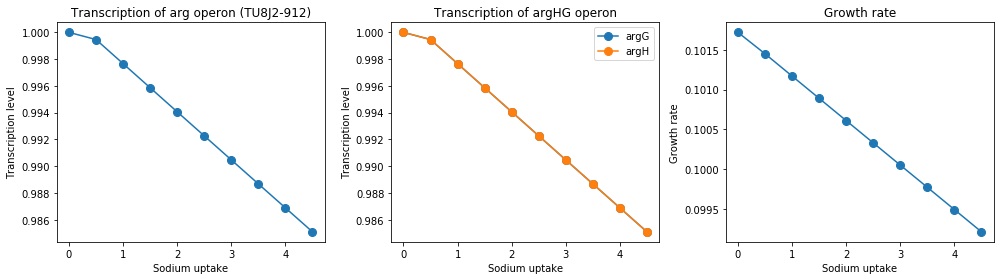

In [52]:
# Visualize transcription profiles
plt.figure(figsize=(14,4))

# TU8J2-912 operon: argCJBDF-carAB
plt.subplot(1,3,1)
expression = flux_responses_me.loc['transcription_TU8J2_912_from_BSU25200-MONOMER']/flux_responses_me.loc['biomass_dilution']
plt.plot(-flux_responses_me.loc['EX_na1_in'],
         expression/max(expression),
         marker = 'o',markersize=8)
plt.title('Transcription of arg operon (TU8J2-912)')
plt.ylabel('Transcription level')
plt.xlabel('Sodium uptake')

# argHG transcription
plt.subplot(1,3,2)
expression = flux_responses_me.loc['transcription_TU_BSU29450']/flux_responses_me.loc['biomass_dilution']
plt.plot(-flux_responses_me.loc['EX_na1_in'],
         expression/max(expression), label='argG',
         marker = 'o',markersize=8)
expression = flux_responses_me.loc['transcription_TU_BSU29440']/flux_responses_me.loc['biomass_dilution']
plt.plot(-flux_responses_me.loc['EX_na1_in'],
         expression/max(expression), label='argH',
         marker = 'o',markersize=8)
plt.legend()
plt.title('Transcription of argHG operon')
plt.ylabel('Transcription level')
plt.xlabel('Sodium uptake')

plt.subplot(1,3,3)
plt.plot(-flux_responses_me.loc['EX_na1_in'],
         flux_responses_me.loc['biomass_dilution'],
         marker = 'o',markersize=8)
plt.title('Growth rate')
plt.ylabel('Growth rate')
plt.xlabel('Sodium uptake')


plt.tight_layout()

Text(0.5, 1.0, 'artPQR')

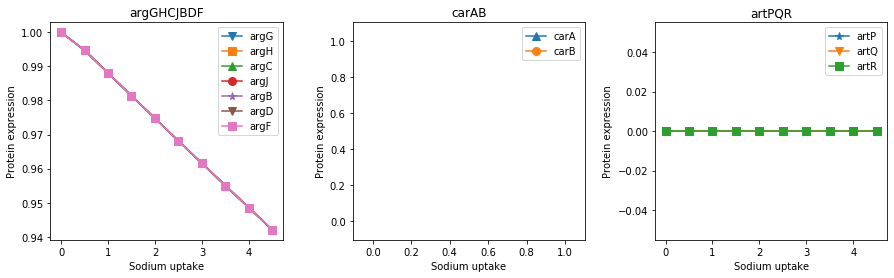

In [53]:
# Visualize protein expression profiles
plt.figure(figsize=(15,4))
import itertools
marker = itertools.cycle(('v', 's', '^', 'o', '*')) 

flux_responses_me[abs(flux_responses_me)<1e-16] = 0

plt.subplots_adjust(wspace=0.3)
plt.subplot(1,3,1)
genes = ['argG', 'argH', 'argC', 'argJ', 'argB', 'argD', 'argF']
for gene_name,locus_id in gene_dictionary.loc[genes]['locus_id'].items():
    expression = flux_responses_me.loc['translation_'+locus_id]
    expression /= np.max(expression)
    plt.plot(-flux_responses_me.loc['EX_na1_in'],expression,
            label=gene_name,marker = next(marker),markersize=8)
plt.legend()
plt.xlabel('Sodium uptake')
plt.ylabel('Protein expression')
plt.title('argGHCJBDF')

plt.subplot(1,3,2)
genes = ['carA', 'carB']
for gene_name,locus_id in gene_dictionary.loc[genes]['locus_id'].items():
    expression = flux_responses_me.loc['translation_'+locus_id]
    expression /= np.max(expression)
    plt.plot(-flux_responses_me.loc['EX_na1_in'],expression,
            label=gene_name,marker = next(marker),markersize=8)
plt.legend()
plt.xlabel('Sodium uptake')
plt.ylabel('Protein expression')
plt.title('carAB')

plt.subplot(1,3,3)
genes = ['artP', 'artQ','artR']
for gene_name,locus_id in gene_dictionary.loc[genes]['locus_id'].items():
    expression = flux_responses_me.loc['translation_'+locus_id]
    plt.plot(-flux_responses_me.loc['EX_na1_in'],expression,
            label=gene_name,marker = next(marker),markersize=8)
plt.legend()
plt.xlabel('Sodium uptake')
plt.ylabel('Protein expression')
plt.title('artPQR')

# artPQR are not included in the model

Notes:
* Sodium was forced to go through the model by creating na1_in and na1_out. Otherwise, it would have exited the model without going through the network from EX to DM

## Accuracy of prediction of transcription response

In [218]:
transcription_response = flux_responses_me.loc[flux_responses_me.index.str.contains('translation')]
all_genes = [gene.split('_')[1] for gene in transcription_response.index]
transcription_df = pd.DataFrame(data=transcription_response.values,index=all_genes,columns=transcription_response.columns)
# Only expressed genes
transcription_df = transcription_df[transcription_df.any(axis=1)]

What should be the threshold to identify up or downregulation in the model?

In [381]:
thresholds = np.arange(0,0.05,0.001)
accuracies = pd.DataFrame(index=thresholds,columns=['TPR','FNR','FDR'])
for threshold in thresholds:

    predicted_fold_change = ((transcription_df['-4.5']-transcription_df['-0.0'])/transcription_df['-0.0'])

    upregulated_genes = predicted_fold_change[predicted_fold_change>threshold]
    downregulated_genes = predicted_fold_change[predicted_fold_change<-threshold]
    rest_genes = predicted_fold_change[abs(predicted_fold_change)<=threshold]

    predicted_decision = pd.DataFrame(data=np.zeros(len(transcription_df.index)),index=transcription_df.index,columns=['reg'])
    predicted_decision.loc[upregulated_genes.index]= 1
    predicted_decision.loc[downregulated_genes.index] = -1

    decision_results = predicted_decision.join(decision_df,lsuffix='_me',rsuffix='_rna')
    
    
    # Metrics
    P = decision_results[decision_results['reg_rna'] != 0].index
    F = decision_results[decision_results['reg_rna'] == 0].index
    pP = decision_results[decision_results['reg_me'] != 0].index
    pF = decision_results[decision_results['reg_me'] == 0].index

    TP = len(set(P)&set(pP))
    FP = len(pP)-TP
    TN = len(set(F)&set(pF))
    FN = len(pF)-TN

    TPR = TP/(TP+FN)
    FNR = TN/(TN+FP)

    prec = TP/(TP+FP)
    FDR = 1-prec
    
    accuracies.loc[threshold]['TPR'] = TPR
    accuracies.loc[threshold]['FNR'] = FNR
    accuracies.loc[threshold]['FDR'] = FDR

    correct = sum(decision_results['reg_me'] == decision_results['reg_rna'])
    incorrect = len(decision_results.index)-correct

    accuracy = correct/len(decision_results.index)

Text(0, 0.5, 'Metric')

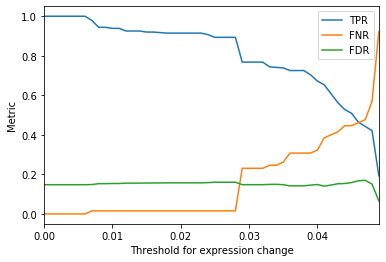

In [384]:
accuracies.plot()
plt.xlabel('Threshold for expression change')
plt.ylabel('Metric')

Seems like the model is able to capture regulation with small changes. Threshold of 0 is the best for accuracy.

In [356]:
threshold = 0.
predicted_fold_change = ((transcription_df['-4.5']-transcription_df['-0.0'])/transcription_df['-4.5'])

upregulated_genes = predicted_fold_change[predicted_fold_change>threshold]
downregulated_genes = predicted_fold_change[predicted_fold_change<-threshold]
rest_genes = predicted_fold_change[abs(predicted_fold_change)<=threshold]

predicted_decision = pd.DataFrame(data=np.zeros(len(transcription_df.index)),index=transcription_df.index,columns=['reg'])
predicted_decision.loc[upregulated_genes.index]= 1
predicted_decision.loc[downregulated_genes.index] = -1

decision_results = predicted_decision.join(decision_df,lsuffix='_me',rsuffix='_rna')
decision_results

correct = sum(decision_results['reg_me'] == decision_results['reg_rna'])
incorrect = len(decision_results.index)-correct

accuracy = correct/len(decision_results.index)
accuracies.append(accuracy)

Text(0.5, 1.0, 'Regulation of active genes in the model')

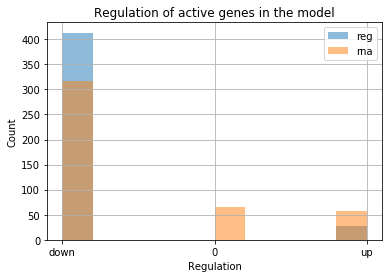

In [357]:
decision_results['reg_me'].hist(alpha=0.5,label='reg')
decision_results['reg_rna'].hist(alpha=0.5,label='rna')

plt.legend()
plt.xlabel('Regulation')
plt.ylabel('Count')
plt.xticks([-1,0,1], ['down',0,'up'])
plt.title('Regulation of active genes in the model')

In [302]:
decision_results[decision_results['reg_me']<0].to_csv('reg_me.csv')

In [303]:
decision_results[decision_results['reg_rna']<0].to_csv('reg_rna.csv')